In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

# Global configuration
FILENAME = "dataset/dataset_Abu Dhabi_2025.csv"


In [118]:
# 1. DATA LOADING
try:
    df = pd.read_csv(FILENAME)
    print(f"Dataset successfully loaded: {len(df)} rows found.")
    
    # Ensure DRS and other categorical data are correctly typed
    if 'DRS' in df.columns:
        df['DRS'] = df['DRS'].astype(int)
        
except FileNotFoundError:
    print(f"Error: The file {FILENAME} was not found. Please check the path.")

Dataset successfully loaded: 197838 rows found.


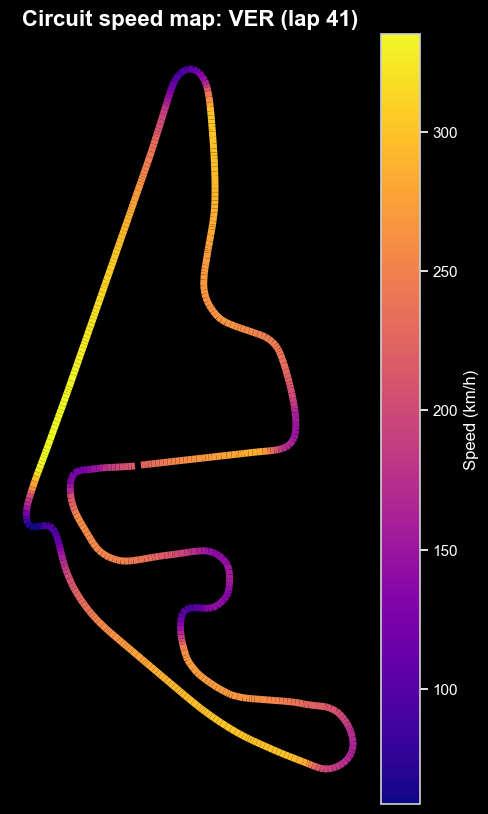

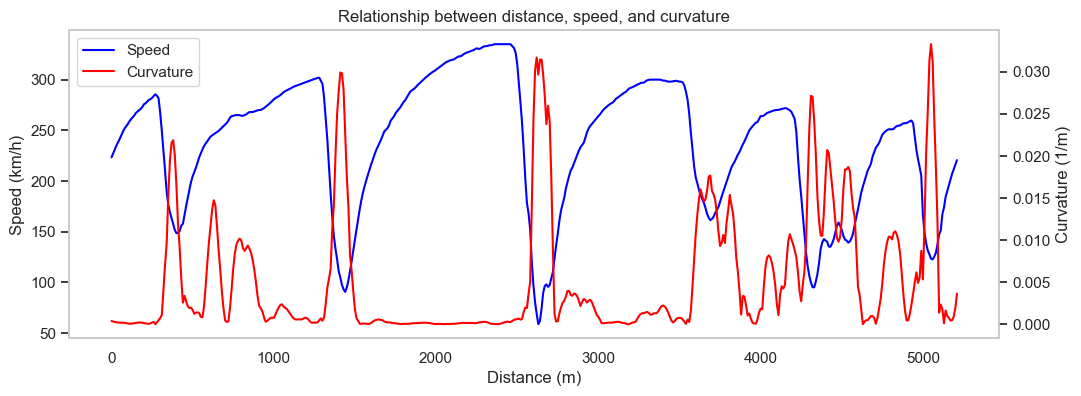

In [119]:
# 2. FASTEST LAP TELEMETRY MAP
driver_to_plot = 'VER'
driver_df = df[df['Driver'] == driver_to_plot]

# Identify the lap with the highest mean speed 
fastest_lap_num = driver_df.groupby('LapNumber')['Speed'].mean().idxmax()
lap_data = driver_df[driver_df['LapNumber'] == fastest_lap_num].sort_values(by='Space_Distance').copy()

# Prepare segments for colored LineCollection
x = lap_data['X_Coord'].values
y = lap_data['Y_Coord'].values
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Variable to map 
variable = lap_data['Speed'].values

# Create figure
fig, ax = plt.subplots(figsize=(15, 10), facecolor='black')
cmap = plt.get_cmap('plasma')
norm = plt.Normalize(variable.min(), variable.max())
lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=5)

lc.set_array(variable)
line = ax.add_collection(lc)

# Aesthetics and colorbar
cbar = fig.colorbar(line, ax=ax, pad=0.01)
cbar.set_label('Speed (km/h)', color='white', fontsize=12)
cbar.ax.yaxis.set_tick_params(colors='white')

ax.axis('off')
ax.set_aspect('equal')

plt.title(f"Circuit speed map: {driver_to_plot} (lap {fastest_lap_num})", 
          color='white', fontsize=16, fontweight='bold')

# Plotting DRS zones
drs_zones = lap_data[lap_data['DRS'] == 1]
ax.scatter(drs_zones['X_Coord'], drs_zones['Y_Coord'], color='lime', s=2, alpha=0.3, label='DRS Active')

plt.show()

# Extra analysis: speed vs curvature profile
fig, ax1 = plt.subplots(figsize=(12, 4))

lns1 = ax1.plot(lap_data['Space_Distance'], lap_data['Speed'], label='Speed', color='blue')
ax1.set_xlabel("Distance (m)")
ax1.set_ylabel("Speed (km/h)")
ax1.grid(False) 
ax2 = ax1.twinx()
lns2 = ax2.plot(lap_data['Space_Distance'], lap_data['Curvature'], label='Curvature', color='red')
ax2.set_ylabel("Curvature (1/m)")
ax2.grid(False) 

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')

plt.title("Relationship between distance, speed, and curvature")
plt.show()

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


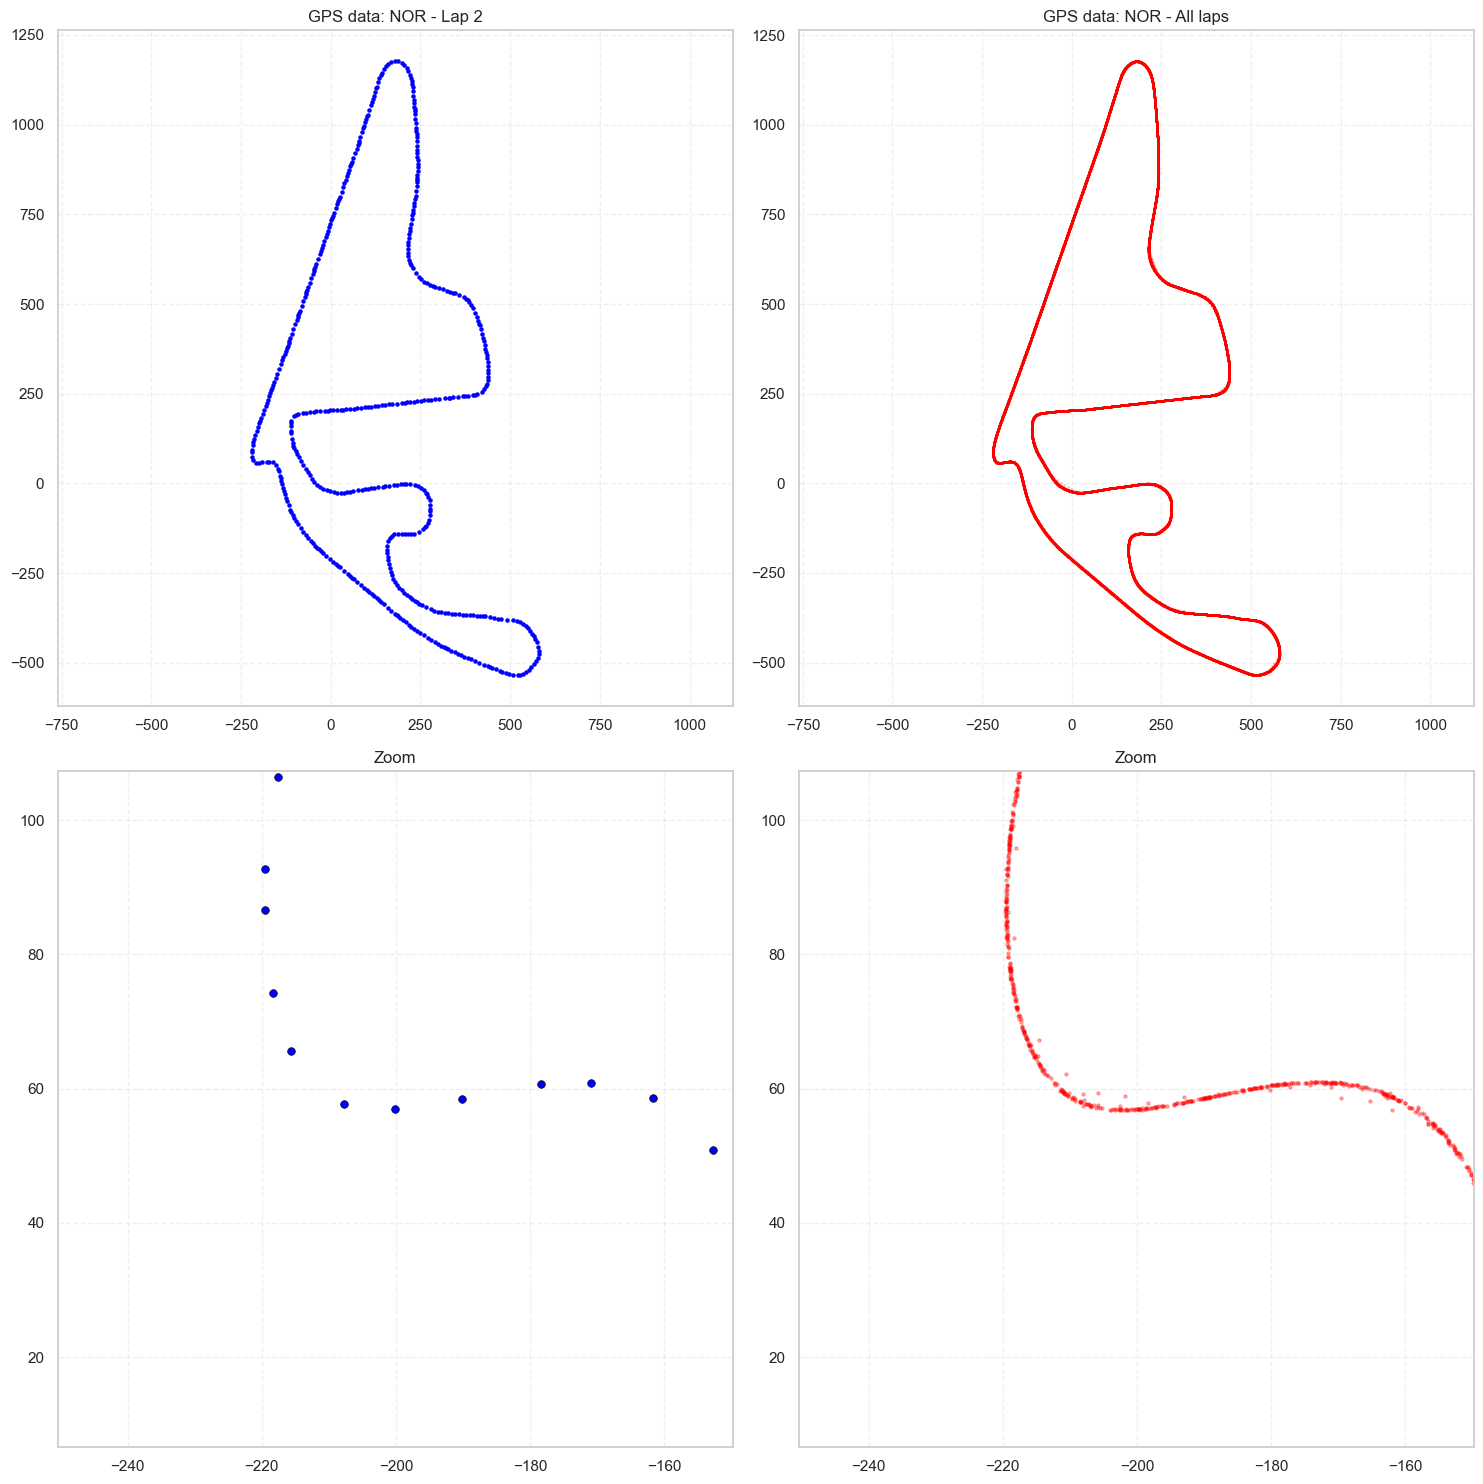

In [120]:
# 3. GPS RAW DATA VISUALIZATION
DRIVER_ID = 'NOR'
driver_df_gps = df[df['Driver'] == DRIVER_ID]

# Subplot 1: Single lap trajectory
single_lap_num = driver_df_gps['LapNumber'].min() 
one_lap_df = driver_df_gps[driver_df_gps['LapNumber'] == single_lap_num]

# Identify the point of maximum curvature to center the zoom on a corner
corner_idx = one_lap_df['Curvature'].idxmax()
center_x = one_lap_df.loc[corner_idx, 'X_Coord']
center_y = one_lap_df.loc[corner_idx, 'Y_Coord']
zoom_size = 50  # zoom window 

plt.figure(figsize=(15, 15))

# Top left: full circuit (single lap)
plt.subplot(2, 2, 1)
plt.scatter(one_lap_df['X_Coord'], one_lap_df['Y_Coord'], color='blue', s=5)
plt.title(f"GPS data: {DRIVER_ID} - Lap {single_lap_num}")
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.3)

# Top right: full circuit (all laps)
# Subplot 2: multi-lap density 
plt.subplot(2, 2, 2)
plt.scatter(driver_df_gps['X_Coord'], driver_df_gps['Y_Coord'], color='red', s=1, alpha=0.2)
plt.title(f"GPS data: {DRIVER_ID} - All laps")
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.3)

# --- BOTTOM LEFT: ZOOMED CORNER (SINGLE LAP) ---
# Showing the real distance between GPS sampling points
plt.subplot(2, 2, 3)
plt.scatter(one_lap_df['X_Coord'], one_lap_df['Y_Coord'], color='blue', s=30, edgecolors='black', linewidth=0.5)
plt.title(f"Zoom")
plt.axis('equal')
plt.xlim(center_x - zoom_size, center_x + zoom_size)
plt.ylim(center_y - zoom_size, center_y + zoom_size)
plt.grid(True, linestyle='--', alpha=0.3)

# --- BOTTOM RIGHT: ZOOMED CORNER (ALL LAPS) ---
# Showing trajectory consistency and dispersion across the same corner
plt.subplot(2, 2, 4)
plt.scatter(driver_df_gps['X_Coord'], driver_df_gps['Y_Coord'], color='red', s=5, alpha=0.3)
plt.title(f"Zoom")
plt.axis('equal')
plt.xlim(center_x - zoom_size, center_x + zoom_size)
plt.ylim(center_y - zoom_size, center_y + zoom_size)
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_12116\3137763739.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels([f'{D2} +{v_max}', '', 'Equal', '', f'{D1} +{v_max}'])


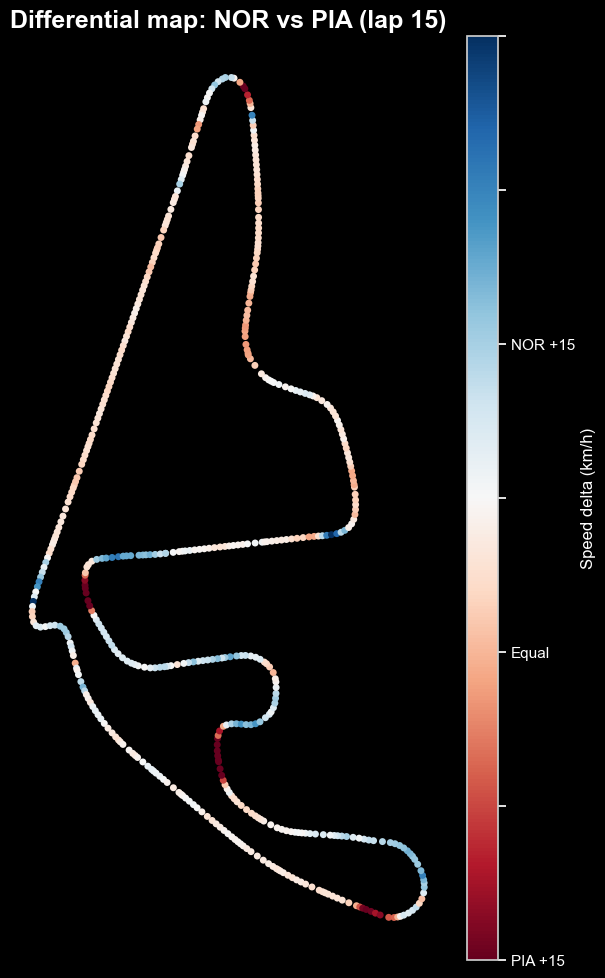

In [121]:
# 4. PERFORMANCE DIFFERENTIAL ANALYSIS (DRIVER COMPARISON)
D1, D2 = 'NOR', 'PIA'
LAP_NUM = 15

# Filtering and synchronizing telemetry based on Space_Distance
d1_data = df[(df['Driver'] == D1) & (df['LapNumber'] == LAP_NUM)].sort_values('Space_Distance')
d2_data = df[(df['Driver'] == D2) & (df['LapNumber'] == LAP_NUM)].sort_values('Space_Distance')

merged = pd.merge(d1_data, d2_data, on='Space_Distance', suffixes=('_D1', '_D2'))
merged['Delta_Speed'] = merged['Speed_D1'] - merged['Speed_D2']

# Visualization: single lap differential map
plt.figure(figsize=(15, 12), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

v_max = 15 
sc = ax.scatter(merged['X_Coord_D1'], merged['Y_Coord_D1'], c=merged['Delta_Speed'], 
                cmap='RdBu', s=25, vmin=-v_max, vmax=v_max, edgecolors='none')

# Aesthetics and colorbar
cbar = plt.colorbar(sc, pad=0.02, aspect=30)
cbar.set_label('Speed delta (km/h)', color='white', fontsize=12)
cbar.ax.yaxis.set_tick_params(colors='white')

# Customizing colorbar ticks for clarity
cbar.ax.set_yticklabels([f'{D2} +{v_max}', '', 'Equal', '', f'{D1} +{v_max}'])

plt.title(f"Differential map: {D1} vs {D2} (lap {LAP_NUM})", color='white', fontsize=18, fontweight='bold')
ax.set_aspect('equal')
ax.axis('off')

plt.show()

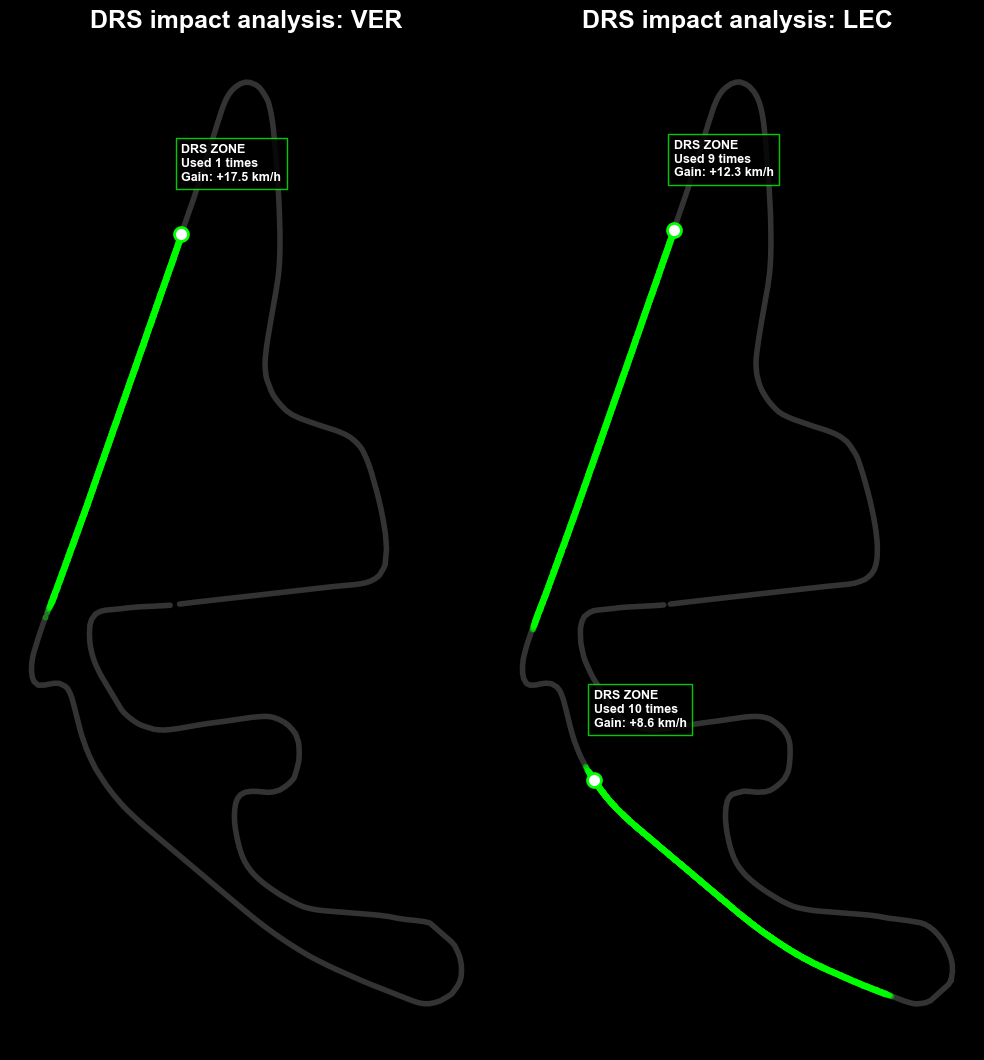

In [122]:
# 6. DRS ACTIVATION AND EFFICIENCY ANALYSIS
DRIVERS_TO_COMPARE = ['VER', 'LEC']
fig, axes = plt.subplots(1, 2, figsize=(10, 12), facecolor='black')

for i, DRIVER in enumerate(DRIVERS_TO_COMPARE):
    ax = axes[i]
    df_driver = df[df['Driver'] == DRIVER].copy()

    # Identification of DRS activation points
    df_driver['DRS_Active'] = df_driver['DRS'].astype(int)
    df_driver['DRS_Activation'] = df_driver.groupby('LapNumber')['DRS_Active'].diff().fillna(0)

    # Extract spatial points where DRS was active at least once
    drs_points = np.sort(df_driver[df_driver['DRS_Active'] == 1]['Space_Distance'].unique())

    if len(drs_points) > 0:
        # Cluster spatial points into distinct DRS zones (threshold: 300m)
        z_diff = np.where(np.diff(drs_points) > 300)[0]
        z_bounds = np.split(drs_points, z_diff + 1)

        results = []
        for zone in z_bounds:
            if len(zone) < 2: continue
            z_min, z_max = zone.min(), zone.max()
            data_zone = df_driver[(df_driver['Space_Distance'] >= z_min) & (df_driver['Space_Distance'] <= z_max)]
            
            speed_on = data_zone[data_zone['DRS_Active'] == 1]['Speed'].mean()
            speed_off = data_zone[data_zone['DRS_Active'] == 0]['Speed'].mean()
            
            if pd.notna(speed_on) and pd.notna(speed_off):
                gain = speed_on - speed_off
                count = data_zone[data_zone['DRS_Activation'] == 1]['LapNumber'].nunique()
                sample = data_zone[data_zone['DRS_Active'] == 1].iloc[0]
                results.append({'z_min': z_min, 'z_max': z_max, 'gain': gain, 'count': count, 'x': sample['X_Coord'], 'y': sample['Y_Coord']})

        # Plotting DRS analysis
        ax.set_facecolor('black')
        
        # Reference track line
        ref_lap = df_driver[df_driver['LapNumber'] == df_driver['LapNumber'].iloc[0]].sort_values('Space_Distance')
        ax.plot(ref_lap['X_Coord'], ref_lap['Y_Coord'], color='#333333', linewidth=4, zorder=1)

        for res in results:
            zone_pts = df_driver[(df_driver['Space_Distance'] >= res['z_min']) & (df_driver['Space_Distance'] <= res['z_max'])]
            ax.scatter(zone_pts['X_Coord'], zone_pts['Y_Coord'], c='lime', s=10, alpha=0.3)
            ax.scatter(res['x'], res['y'], color='white', s=100, edgecolors='lime', linewidth=2, zorder=3)
            ax.text(res['x'], res['y'] + 100, f"DRS ZONE\nUsed {res['count']} times\nGain: +{res['gain']:.1f} km/h", 
                     color='white', fontsize=9, fontweight='bold', bbox=dict(facecolor='black', alpha=0.8, edgecolor='lime'))

    ax.set_title(f"DRS impact analysis: {DRIVER}", color='white', fontsize=18, fontweight='bold')
    ax.set_aspect('equal')
    ax.axis('off')

plt.tight_layout()
plt.show()

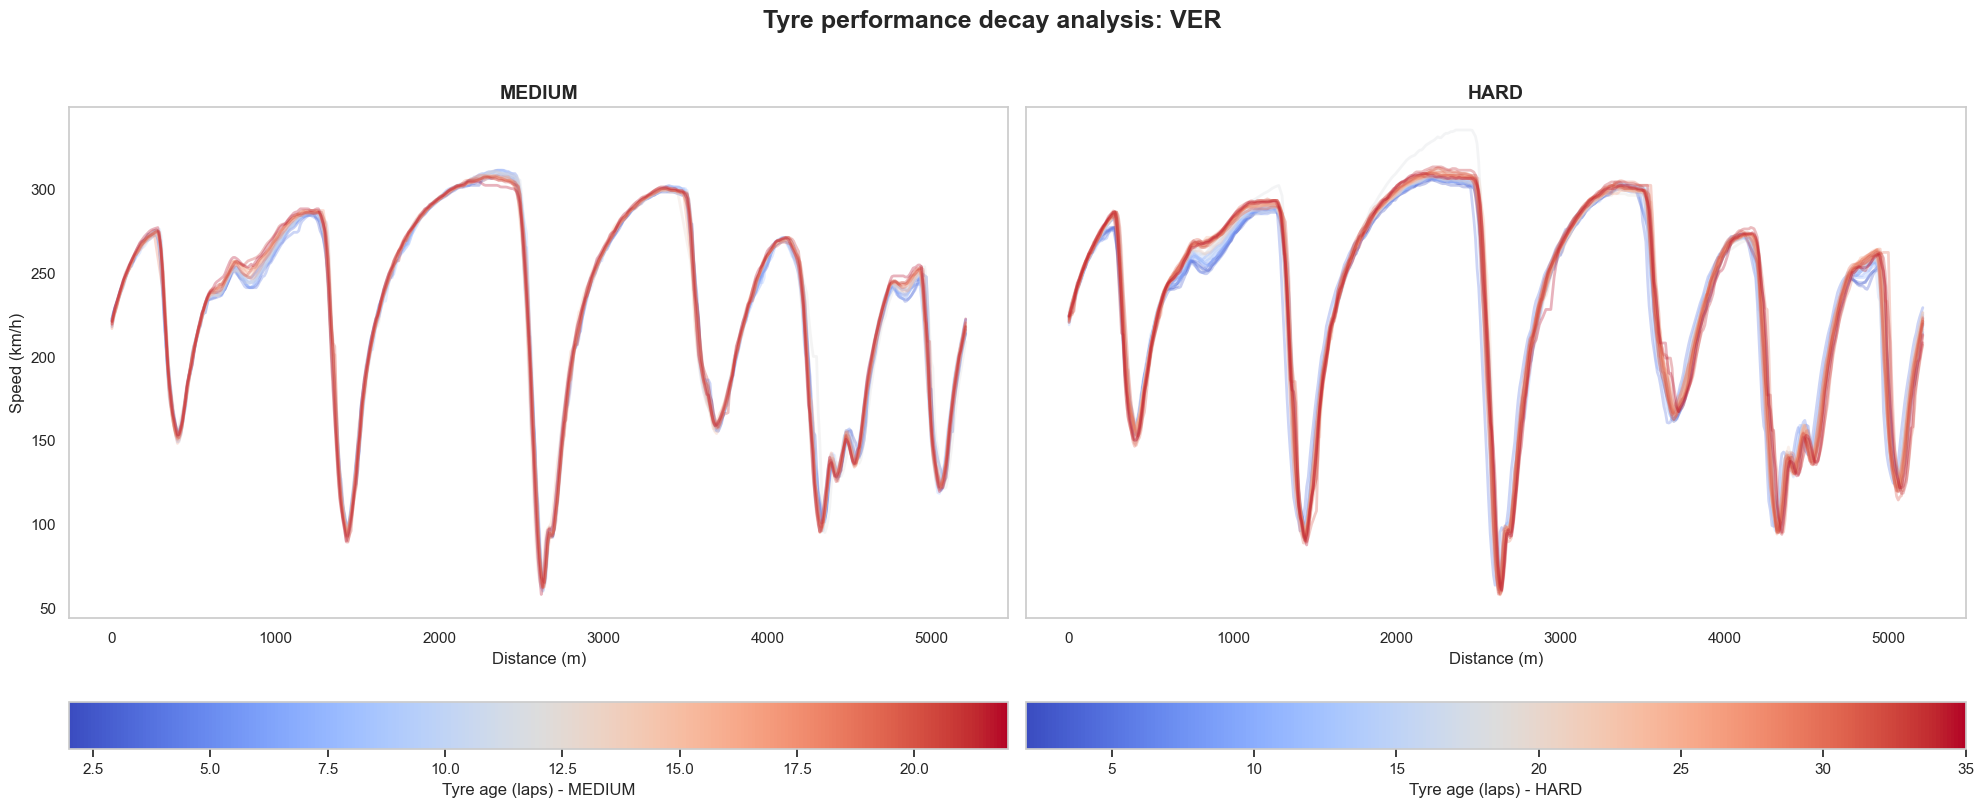

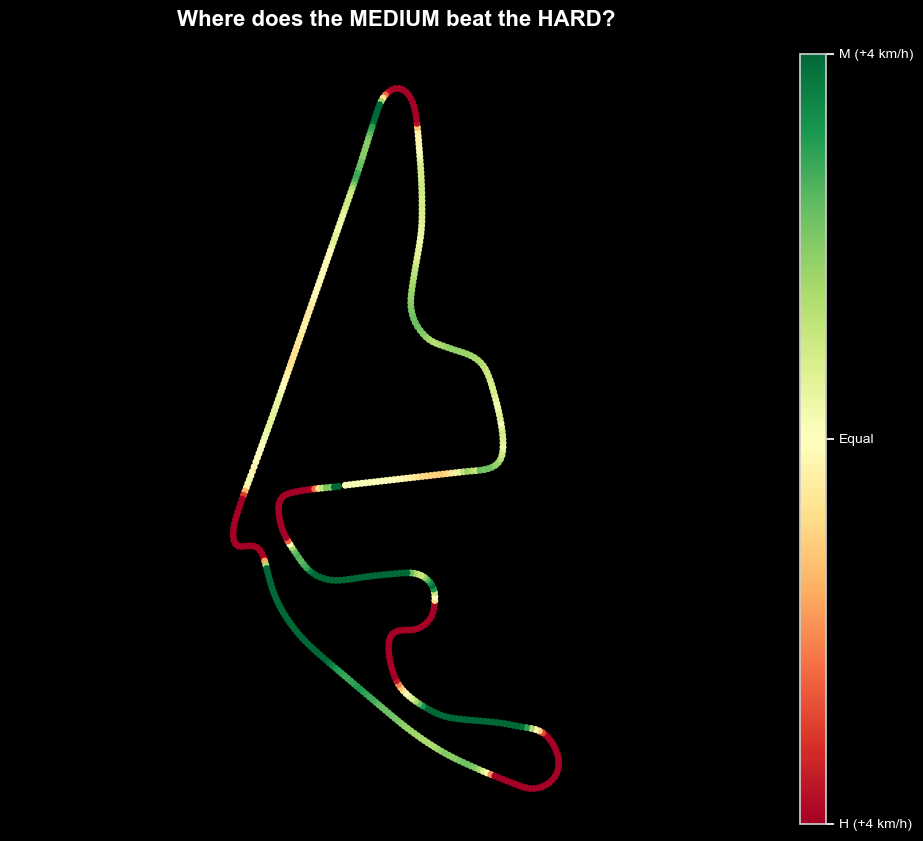

In [123]:
# 7. TYRE DEGRADATION AND COMPOUND PERFORMANCE
driver_to_analyze = 'VER'
compounds = ['MEDIUM', 'HARD']

# Creating a side-by-side comparison of speed decay over tyre life
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True, facecolor='white')

for i, comp in enumerate(compounds):
    ax = axes[i]
    df_sub = df[(df['Driver'] == driver_to_analyze) & (df['Compound'] == comp)].copy()
    
    if not df_sub.empty:
        # Normalize color mapping based on tyre age (Cool = New, Warm = Old)
        norm = plt.Normalize(df_sub['TyreLife'].min(), df_sub['TyreLife'].max())
        cmap = plt.get_cmap('coolwarm')
        
        # Plot each lap's speed profile
        for life in sorted(df_sub['TyreLife'].unique()):
            lap_data = df_sub[df_sub['TyreLife'] == life].sort_values('Space_Distance')
            ax.plot(lap_data['Space_Distance'], lap_data['Speed'], color=cmap(norm(life)), alpha=0.3, linewidth=2)
        
        # Adding a horizontal colorbar for tyre age
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.12)
        cbar.set_label(f'Tyre age (laps) - {comp}')
        
        ax.set_title(f"{comp}", fontsize=14, fontweight='bold')
        ax.set_xlabel("Distance (m)")
        if i == 0: ax.set_ylabel("Speed (km/h)")
        ax.grid(False) 

plt.suptitle(f"Tyre performance decay analysis: {driver_to_analyze}", fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Compound advantage map
# Comparing fresh Medium vs fresh Hard (< 10 laps) to identify performance deltas
fresh_med = df[(df['Compound'] == 'MEDIUM') & (df['TyreLife'] <= 10)].groupby('Space_Distance')['Speed'].mean()
fresh_hard = df[(df['Compound'] == 'HARD') & (df['TyreLife'] <= 10)].groupby('Space_Distance')['Speed'].mean()

# Calculate delta 
delta_compounds = (fresh_med - fresh_hard).dropna()

# Retrieve coordinates for the common spatial points
coords = df.groupby('Space_Distance')[['X_Coord', 'Y_Coord']].mean().reindex(delta_compounds.index)

plt.figure(figsize=(12, 10), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

# Using red-yellow-green: 
v_range = 4
sc = plt.scatter(coords['X_Coord'], coords['Y_Coord'], c=delta_compounds, cmap='RdYlGn', s=25, vmin=-v_range, vmax=v_range, edgecolors='none')

# Colorbar customization
cbar = plt.colorbar(sc, pad=0.02, aspect=30)
cbar.ax.yaxis.set_tick_params(colors='white')

# Setting specific labels for the colorbar to indicate compound advantage
cbar.set_ticks([-v_range, 0, v_range])
cbar.ax.set_yticklabels([f'H (+{v_range} km/h)', 'Equal', f'M (+{v_range} km/h)'], 
                        color='white', fontsize=10)

plt.title("Where does the MEDIUM beat the HARD?", color='white', fontsize=16, fontweight='bold', pad=20)
plt.axis('equal')
plt.axis('off')

plt.show()

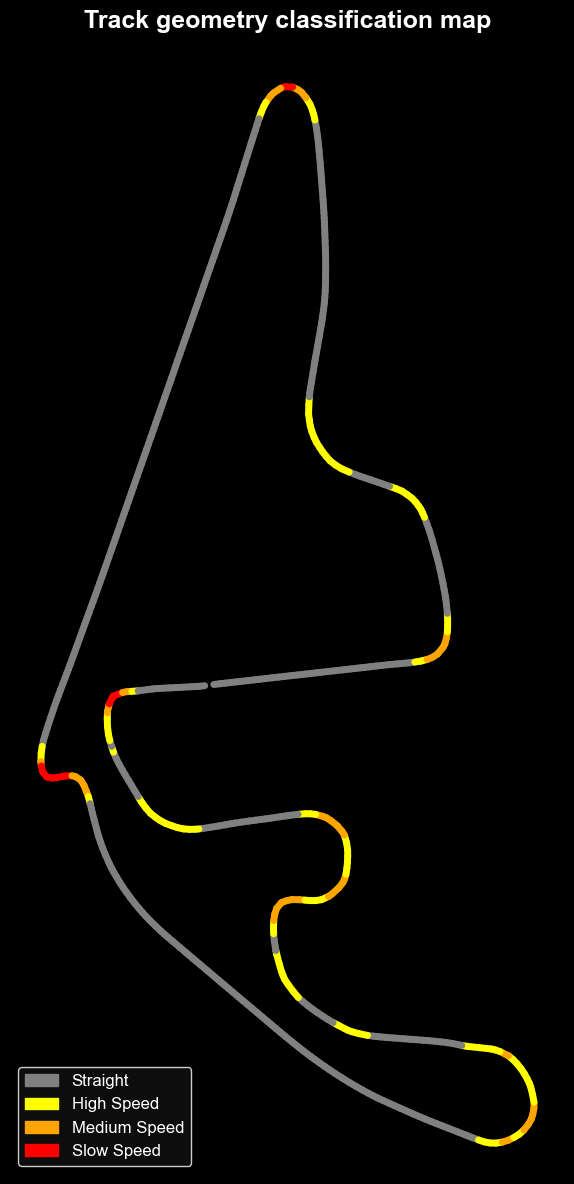

In [126]:
# 8. TRACK GEOMETRY CLASSIFICATION MAP
driver_to_plot = 'VER'
driver_df = df[df['Driver'] == driver_to_plot]

# Identify the lap with the highest mean speed
fastest_lap_num = driver_df.groupby('LapNumber')['Speed'].mean().idxmax()
lap_data = driver_df[driver_df['LapNumber'] == fastest_lap_num].sort_values(by='Space_Distance').copy()

# Robust categorization mapping for analysis
category_map = {
    'Type_Straight':    {'color': '#808080', 'label': 'Straight'},
    'Type_HighSpeed':   {'color': '#FFFF00', 'label': 'High Speed'},
    'Type_MediumSpeed': {'color': '#FFA500', 'label': 'Medium Speed'},
    'Type_SlowSpeed':   {'color': '#FF0000', 'label': 'Slow Speed'}
}

# Filtering active classification columns from the dataset
available_cols = [c for c in category_map.keys() if c in lap_data.columns]

if not available_cols:
    print("Error: Categorization columns missing in the dataset.")
else:
    # Assigning numerical indices for colormap mapping
    lap_data['Category_Idx'] = np.argmax(lap_data[available_cols].values, axis=1)

    # Colormap and normalization setup
    colors = [category_map[col]['color'] for col in available_cols]
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(np.arange(-0.5, len(available_cols), 1), cmap.N)

    # Building spatial segments from coordinates
    x = lap_data['X_Coord'].values
    y = lap_data['Y_Coord'].values
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Figure initialization with black background
    fig, ax = plt.subplots(figsize=(12, 12), facecolor='black')
    ax.set_facecolor('black')

    # Rendering the circuit via LineCollection
    lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=5, capstyle='round', zorder=2)
    lc.set_array(lap_data['Category_Idx'].values)
    ax.add_collection(lc)

    # Limit settings
    buffer = 50
    ax.set_xlim(x.min() - buffer, x.max() + buffer)
    ax.set_ylim(y.min() - buffer, y.max() + buffer)
    ax.set_aspect('equal')
    ax.axis('off')

    # Legend construction
    patches = [mpatches.Patch(color=category_map[col]['color'], 
                              label=category_map[col]['label']) for col in available_cols]

    leg = ax.legend(handles=patches, loc='lower left', facecolor='#111111', 
                   edgecolor='white', labelcolor='white', fontsize=12)
    leg.get_title().set_color('white')

    plt.title(f"Track geometry classification map", 
              color='white', fontsize=18, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()